<a href="https://colab.research.google.com/github/4elvis/Twitter-Sentiment-Analysis/blob/main/YellowStone_Remix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Loading packages

In [ ]:
!pip install snscrape

!pip3 install ktrain

!python -m pip install tensorflow_text

!pip install transformers

     |████████████████████████████████| 25.3 MB 2.2 MB/s 
     |████████████████████████████████| 22.3 MB 6.9 MB/s 
     |████████████████████████████████| 981 kB 13.9 MB/s 
     |████████████████████████████████| 263 kB 30.2 MB/s 
     |████████████████████████████████| 2.8 MB 31.5 MB/s 
     |████████████████████████████████| 1.2 MB 34.2 MB/s 
     |████████████████████████████████| 468 kB 38.1 MB/s 
     |████████████████████████████████| 895 kB 31.0 MB/s 
     |████████████████████████████████| 3.3 MB 34.1 MB/s 
     |████████████████████████████████| 77 kB 5.7 MB/s 
     |████████████████████████████████| 596 kB 31.6 MB/s 
  Created wheel for ktrain: filename=ktrain-0.30.0-py3-none-any.whl size=25309161 sha256=d997ad80c339695d450e6332d0e7cf72301a6eefaea62d27ec260119543df95d
  Stored in directory: /root/.cache/pip/wheels/25/00/ae/80d1b19dd02bc2e6bc9bac32ba7dbaa59aad789e93274e4868
  Created wheel for keras-bert: filename=keras_bert-0.89.0-py3-none-any.whl size=33517 sha256=e1ad8bce8

In [ ]:
# Importing Libraries
#
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import ktrain
from ktrain import text
import tensorflow_hub as hub
import tensorflow_text as text
from sklearn.metrics import confusion_matrix, classification_report
from matplotlib import pyplot as plt
import seaborn as sn
import os
import snscrape.modules.twitter as sntwitter
import re, string
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
from textblob import TextBlob
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB  
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Importing lemmatization libraries
import nltk

from nltk.stem.wordnet import WordNetLemmatizer
from wordcloud import WordCloud, STOPWORDS
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Functions

In [ ]:
#function for sorting the multiple hashes and multiple @
#also sorts out @'s and # that occur within text
# changes lonesome @ to at
def find_the (text):
    while len(re.findall('##' , text)) != 0:
        text = re.sub('##' , '#' ,text)
    while len(re.findall('@@' , text)) != 0:
        text = re.sub('@@' , '@' ,text)

    no_h = len(re.findall('#',text))
    #make sure the @ is changed for at
    no_a = len(re.findall('@',text))
    
    text = re.sub('@(\s|\.|\?|,|;|:|!|\(|\))', 'at' , text)
    text = re.sub('\s' , ' ' , text)
    text = re.sub('\S@' , ' @' , text)
    text = re.sub('\S#' , ' #' , text)

    #while len(re.findall('\s\s' , text)) != 0:
    #    text = re.sub('\s\s' , '\s' ,text)

    #none_repeat = text
    text_a = text.split()

            
    return text

In [ ]:
# Applying Lemmmatizer to remove tenses from texts.
lemmatizer = WordNetLemmatizer()
#stemmer = SnowballStemmer("english")
STOPWORDS.update(['mkr', 'didn', 'bc', 'n', 'm', 
                  'im', 'll', 'y', 've', 'u', 'ur', 'don', 
                  'p', 't', 's', 'aren', 'kp', 'o', 'kat', 
                  'de', 're', 'amp', 'will'])# 'rt'
corpus = []
def preprocess_tweet(tweet):
    tweet = re.sub(r"won\'t", "will not", tweet)
    tweet = re.sub(r"can\'t", "can not", tweet)
    tweet = re.sub(r"n\'t", " not", tweet)
    tweet = re.sub(r"\'re", " are", tweet)
    tweet = re.sub(r"\'s", " is", tweet)
    tweet = re.sub(r"\'d", " would",tweet)
    tweet = re.sub(r"\'ll", " will", tweet)
    tweet = re.sub(r"\'t", " not", tweet)
    tweet = re.sub(r"\'ve", " have", tweet)
    tweet = re.sub(r"\'m", " am", tweet)
    #tweet = re.sub('[^a-zA-Z]',' ',tweet)
    #tweet = re.sub(r'[^\x00-\x7f]','',tweet)
    #tweet = " ".join([stemmer.stem(word) for word in tweet.split()])
    tweet = [lemmatizer.lemmatize(word) for word in tweet.split() if not word in set(STOPWORDS)]
    tweet = ' '.join(tweet)
    return tweet

In [ ]:
# Creating a tag maker function to extract @'s and #'s as the data is cleaned by the lemmatizer so as not to alter the tags
def tag_maker (text):
  text_a = text.split()
  tag_a = []
  for r in range(0, len(text_a)):
    if text_a[r].startswith('#') or text_a[r].startswith('@'):
      tag_name = '<<yellowstone<<' + str(len(tag_a)) + '>>yellowstone>>'
      tag_a.append(text_a[r])
      text_a[r] = tag_name

  r_text = ' '.join(text_a)

  return [r_text , tag_a]

  

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


In [ ]:
# Creating a tag replacer function replaces tags from text that has been lematized to the original @'s and #'s


def tag_replacer (text , tag_a):
  text_a = text.split()

  for r in range(0, len(text_a)):
    if ('<<yellowstone<<' in text_a[r]) and ('>>yellowstone>>' in text_a[r]):
      num = text_a[r]
      num = num[15:][:-15]
      num = int(num)
      text_a[r] = tag_a[num]

  r_text = ' '.join(text_a)

  return r_text

In [ ]:
# Creating a lema and stem function to call the tag maker the lematizer and the tag replacer

def tags_lema_stem(text):
  for_lem = tag_maker(text)
  for_tag_removal = preprocess_tweet(for_lem[0])
  r_text = tag_replacer(for_tag_removal, for_lem[1])

  return r_text

In [ ]:
# fuction to get the ats and hashes out 

def hash_and_ats (text):
    text_a = text.split()
    hash_list = []
    at_list = []
    
    for a in text_a:
        
        if a.startswith('#'):
            a = a.lower()
            hash_list.append(a)
        elif a.startswith('@'):
            at_list.append(a)

    return [hash_list , at_list]

In [ ]:
# removes words that start with at predefined set of characters in a list
def header_remover(text, hr):
    to_drop = hr
    text_a = text.split()
    for g in range(len(text_a)-1, -1 , -1):
        for a in to_drop:
            if text_a[g].startswith(a):
                text_a.pop(g)
                break

    text = ' '.join(text_a)
    return text

In [ ]:
# Polarity
# Function to get polarity(sentiments) of text using the module textblob
#
def get_polarity(text):
    try:
        textblob = TextBlob(text)
        pol = textblob.sentiment.polarity
    except:
        pol = 0.0
    return pol

In [ ]:
# Subjectivity
# Function to get polatiy of text using the module textblob
def get_subjectivity(text):
    try:
        textblob = TextBlob(text)
        subj = textblob.sentiment.subjectivity
    except:
        subj = 0.0
    return subj

In [ ]:
# Labelling sentiments to either Positive or Negative
#
def positive_negative(f):
	if f < 0:
		return 'Negative'
	else:
		return 'Positive'

In [ ]:
#Visiualization function
#
def bar_outlier (stat_dataframe, threshold):
  sec = stat_dataframe.iloc[1,1]
  fir = stat_dataframe.iloc[0,1]
  if threshold != 0:
    if fir > (sec * threshold):
      stat_dataframe = stat_dataframe.drop(stat_dataframe.index[0])
      stat_dataframe.reset_index(inplace=True)
      stat_dataframe.drop(columns = ['index'] , inplace = True)
  return stat_dataframe

#Visiualization function
#
def make_bars(h_list , entries, f_size, threshold):
  c = collections.Counter(sum(h_list, []))
  hash = pd.DataFrame(c.most_common(entries))
  hash = bar_outlier(hash , threshold)
  fig = plt.figure(figsize = f_size)
  ax = fig.add_axes([0,0,1,1])
  ax.bar(hash[0],hash[1])
  plt.xticks(rotation=60)

In [ ]:
# creating a def function to identify hastags and ats for visualization
#
def for_pie (a,b):
  if a == [] and b == []:
    return 0
  if a == [] and b != []:
    return 1
  if a != [] and b == []:
    return 2
  if a != [] and b != []:
    return 3

# Business Understanding

# Data Understanding

## Data Acquisition

In [ ]:
# Creating list to append tweet data to
tweets_list2 = []

# Using TwitterSearchScraper to scrape data and append tweets to list
for i,tweet in enumerate(sntwitter.TwitterSearchScraper('EABL').get_items()):
    if i>5000:
        break
    tweets_list2.append([tweet.date, tweet.id, tweet.content, tweet.username])
    
# Creating a dataframe from the tweets list above
tweets_df2 = pd.DataFrame(tweets_list2, columns=['Datetime', 'Tweet Id', 'Tweet', 'Username'])

In [ ]:
# Previewing the top 20 of data
#
tweets_df2.head(20)

,Datetime,Tweet Id,Tweet,Username
0,2022-04-20 03:50:43+00:00,1516625382895767555,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,ba94385282
1,2022-04-19 21:57:04+00:00,1516536385620086793,@BSCoachDev @SamNeter Plus the experience as a...,CoachAnt_
2,2022-04-19 21:44:39+00:00,1516533258514796545,@SamNeter The problem is not provision for 16-...,HaringeyHawks
3,2022-04-19 20:27:18+00:00,1516513794763206661,What if Polycarp Igathe finds a job at eabl or...,dkiruy
4,2022-04-19 19:56:38+00:00,1516506077373911045,@artofinvestmnt @DividendIncome_ Example:Safar...,SilasChogo
5,2022-04-19 19:19:20+00:00,1516496689640706048,@mwabilimwagodi Hakikusha uko a EABL shares eq...,kamaukariuki_
6,2022-04-19 18:53:05+00:00,1516490083943264258,It's nice that devs are getting their due. I j...,wa_ndeg
7,2022-04-19 18:47:18+00:00,1516488627223736326,@SamNeter Everyone thinks they know what is be...,UKBall4
8,2022-04-19 15:59:30+00:00,1516446399025467394,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,Zzack00001
9,2022-04-19 14:35:10+00:00,1516425174194831365,Follow Chrome on all social media @Chrome_ke t...,TulizaFM924


In [ ]:
# Preview the shape of data
#
tweets_df2.shape

(5001, 4)

In [ ]:
# preview of 20 random samples
#
tweets_df2.sample(10)

,Datetime,Tweet Id,Tweet,Username
1528,2022-03-04 13:33:21+00:00,1499739778220236806,Within the shortest time in office HE ANNE KAN...,GeneralDon5
3154,2022-01-03 21:01:42+00:00,1478109338044669953,Hello @KenyaBreweries and @EABL_PLC kindly c...,GeorgeWanjiru_k
396,2022-04-03 14:09:48+00:00,1510620585302233088,Nyash has just launched her Shin city rehearsa...,LiveNation254
2562,2022-01-26 14:19:44+00:00,1486343097973891078,🏀 EABL GAMEDAY🛡🗡\n@CantAcadTrust welcome @JmaR...,KentCrusadersBB
766,2022-03-15 14:40:17+00:00,1503742890249695232,thika road service lane heading towards allsop...,KenyanTraffic
2767,2022-01-18 07:18:29+00:00,1483337986225942528,Tabitha Karanja's Keroche breweries is on it's...,Ritchiepreach
4127,2021-11-19 17:14:31+00:00,1461744709383213063,Hii y Leo c legit\nAcha nipigiie EABL😕😕,rechargeable17
185,2022-04-11 03:30:59+00:00,1513358924099035143,Wee Wachana Na Story Kibao\nDon't You Know Fro...,theblackrendile
1093,2022-03-06 08:26:32+00:00,1500387339943694339,Who will be your next president?\n\nDoyen Will...,electionske254
3236,2022-01-01 16:04:38+00:00,1477309803634601984,@NikoSarcevic Now it's fixed,_eabl_


## .........

# Data Preparation

## Cleaning Data

In [ ]:
# dropping irrelevant columns
df = tweets_df2.drop(['Datetime', 'Tweet Id', 'Username'], axis = 1) 

# renaming column 
df.columns = ['tweet']

# previewing datset
df.sample(5)

,tweet
1727,@__derrick9__ @edwardndalo @TuskerLager Kama n...
1803,"@Hamadijuma I have been a fool before,I signed..."
1694,@KenyaBreweries Somebody is asleep on the job ...
2262,@Osama_otero Misleading stereotype. Meru trai...
3443,@BrianFe18453539 Eabl


In [ ]:
# getting non repetitive column
# handling whitespaces
df['nr_tweet'] = df.tweet.apply(lambda d: find_the(d))
df.head()

,tweet,nr_tweet
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...


In [ ]:
# We take the non repetitive tweets and change them to lower case, expose them to the tags_lema_stem 
# as well as, removing the (not so sure) while still maintaining the hashtags and ats



df['c_tweet'] = df['nr_tweet'].str.lower()

df['c_tweet'] = df['c_tweet'].apply (lambda i : tags_lema_stem(i))

df['c_tweet'] = df['c_tweet'].apply(lambda i : re.sub('[^a-zA-Z0-9_#@ ]','',i)) #maintains the hashtags and the @'s

df.head(20)

,tweet,nr_tweet,c_tweet
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...
5,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi hakikusha uko eabl share equiv...
6,It's nice that devs are getting their due. I j...,It's nice that devs are getting their due. I j...,nice devs getting due hope spend money wisely ...
7,@SamNeter Everyone thinks they know what is be...,@SamNeter Everyone thinks they know what is be...,@samneter everyone think know best players let...
8,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@eabl_plc kulewa inadhuru afya ya wananchi ken...
9,Follow Chrome on all social media @Chrome_ke t...,Follow Chrome on all social media @Chrome_ke t...,follow chrome social medium @chrome_ke part st...


In [ ]:
# getting the hashtag and ats columns
#
df['hashtags'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[0])
df['ats'] = df['nr_tweet'].apply(lambda f : hash_and_ats(f)[1])

# preview of random 20 
#
df.sample(2)

,tweet,nr_tweet,c_tweet,hashtags,ats
2787,@thedigitaldiva @EABL_PLC @graham_vt Just at i...,@thedigitaldiva @EABL_PLC @graham_vt Just at i...,@thedigitaldiva @eabl_plc @graham_vt basic mar...,[#imarketpodcast],"[@thedigitaldiva, @EABL_PLC, @graham_vt, @grah..."
1863,Someone asked a very interesting question here...,Someone asked a very interesting question here...,someone asked interesting question here cocaco...,[],[]


In [ ]:
# Removing the hash and Ats

df['m_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#' , '@']))
df['h_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['@']))
df['a_tweet'] = df['c_tweet'].apply(lambda i : header_remover(i , ['#']))

In [ ]:
# the rest of the stats
df['no_of_punctuations'] = df.tweet.apply(lambda x : len(re.findall('[^a-zA-Z0-9_ ]', x)))
df['no_of_at'] = df['ats'].apply ( lambda s : len(s))
df['no_of_hashes'] = df['ats'].apply ( lambda s : len(s))
df['no_of_words'] = df['nr_tweet'].apply ( lambda s : len(s.split()))

# no of words without @
df['no_of_words_no_at'] = df['no_of_words'] - df['no_of_at']

# no of words without #
df['no_of_words_no_hash'] = df['no_of_words'] - df['no_of_hashes']

# no of words without @ and #
df['no_of_words_no_at_hash'] = df['no_of_words'] - df['no_of_at'] - df['no_of_hashes']
df['length_of_tweet'] = df['nr_tweet'].apply (lambda y : len(y))


In [ ]:
# Viewing our current dataset

df.head(20)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...,[],"[@belladonnarthy, @EABL_PLC, @OfficialEABL]",glad help this,glad help this,@belladonnarthy @eabl_plc @officialeabl glad h...,4,3,3,11,8,8,5,75
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...,[],"[@BSCoachDev, @SamNeter]",plus experience whole better here ableabl acad...,plus experience whole better here ableabl acad...,@bscoachdev @samneter plus experience whole be...,7,2,2,26,24,24,22,176
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...,[],[],polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,1,0,0,19,19,19,19,99
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...,[],"[@artofinvestmnt, @DividendIncome_]",examplesafaricom ie mpesa mtn bat ie tobacco e...,examplesafaricom ie mpesa mtn bat ie tobacco e...,@artofinvestmnt @dividendincome_ examplesafari...,7,2,2,13,11,11,9,102
5,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi hakikusha uko eabl share equiv...,[],[@mwabilimwagodi],hakikusha uko eabl share equivalent drink,hakikusha uko eabl share equivalent drink,@mwabilimwagodi hakikusha uko eabl share equiv...,1,1,1,11,10,10,9,72
6,It's nice that devs are getting their due. I j...,It's nice that devs are getting their due. I j...,nice devs getting due hope spend money wisely ...,[],[],nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,12,0,0,36,36,36,36,219
7,@SamNeter Everyone thinks they know what is be...,@SamNeter Everyone thinks they know what is be...,@samneter everyone think know best players let...,[],[@SamNeter],everyone think know best players let make deci...,everyone think know best players let make deci...,@samneter everyone think know best players let...,8,1,1,51,50,50,49,285
8,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,[],"[@EABL_PLC, @DjJoeMfalme, @EABL_PLC]",kulewa inadhuru afya ya wananchi kenya advice ...,kulewa inadhuru afya ya wananchi kenya advice ...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,8,3,3,13,10,10,7,110
9,Follow Chrome on all social media @Chrome_ke t...,Follow Chrome on all social media @Chrome_ke t...,follow chrome social medium @chrome_ke part st...,"[#eabl, #chrome]",[@Chrome_ke],follow chrome social medium part street filoso...,follow chrome social medium part street filoso...,follow chrome social medium @chrome_ke part st...,8,1,1,25,24,24,23,164


## ****Testing for digits

In [ ]:
# contains a list of the beginning of the words that should be dropped
#
header_drop = ['http']

In [ ]:
# Finding the number of digits contained in the tweet
#
df['is_there_digit'] = df['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
# Getting the all the digits that are not 0

m = df[(df['is_there_digit'] != 0)]

In [ ]:
# removing the http from the m

m['m_tweet'] = m['m_tweet'].apply(lambda r : header_remover(r, ['http']))

In [ ]:
m['is_there_digit'] = m['m_tweet'].apply(lambda y : len(re.findall('[0-9]' , y)))

In [ ]:
m[(m['is_there_digit'] != 0)]

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237,8
19,Talk about an incredibly lucky second guess 😀\...,Talk about an incredibly lucky second guess 😀 ...,talk incredibly lucky second guess wordle 303...,[],[],talk incredibly lucky second guess wordle 303 26,talk incredibly lucky second guess wordle 303 26,talk incredibly lucky second guess wordle 303 26,17,0,0,13,13,13,13,74,5
30,The 1st of January 2021 marked the first time ...,The 1st of January 2021 marked the first time ...,1st january 2021 marked first time history ken...,[],"[@SafaricomPLC, @EABL_PLC, @BatKenya]",1st january 2021 marked first time history ken...,1st january 2021 marked first time history ken...,1st january 2021 marked first time history ken...,3,3,3,26,23,23,20,156,5
31,@Njogu_32 @Kamau266 @2njer_i Kwa hiyo biz uko ...,@Njogu_32 @Kamau266 @2njer_i Kwa hiyo biz uko ...,@njogu_32 @kamau266 @2njer_i kwa hiyo biz uko ...,[],"[@Njogu_32, @Kamau266, @2njer_i]",kwa hiyo biz uko na 1 picha ya uhunye well dis...,kwa hiyo biz uko na 1 picha ya uhunye well dis...,@njogu_32 @kamau266 @2njer_i kwa hiyo biz uko ...,25,3,3,33,30,30,27,239,7
32,Muthaiga Golf Club clinch 2022 Tannahill Shiel...,Muthaiga Golf Club clinch 2022 Tannahill Shiel...,muthaiga golf club clinch 2022 tannahill shiel...,[#tannahillshieldtitle2022],"[@MuthaigaGC, @EABL_PLC]",muthaiga golf club clinch 2022 tannahill shiel...,muthaiga golf club clinch 2022 tannahill shiel...,muthaiga golf club clinch 2022 tannahill shiel...,16,2,2,13,11,11,9,150,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4971,East African Breweries Limited's fundamental v...,East African Breweries Limited's fundamental v...,east african brewery limited fundamental valua...,[],[@EABL_PLC],east african brewery limited fundamental valua...,east african brewery limited fundamental valua...,east african brewery limited fundamental valua...,24,1,1,37,36,36,35,300,8
4972,Kama ni #TuskerOktobafest2021 mbona tusker mal...,Kama ni #TuskerOktobafest2021 mbona tusker mal...,kama ni #tuskeroktobafest2021 mbona tusker mal...,[#tuskeroktobafest2021],[@EABL_PLC],kama ni mbona tusker malt tunauziwa 300,kama ni #tuskeroktobafest2021 mbona tusker mal...,kama ni mbona tusker malt tunauziwa 300 @eabl_plc,4,1,1,9,8,8,7,72,3
4978,@EABL_PLC \nMy questions is with regards to th...,@EABL_PLC My questions is with regards to the...,@eabl_plc question regard corporate bond ksh11...,[],[@EABL_PLC],question regard corporate bond ksh11bn raised ...,question regard corporate bond ksh11bn raised ...,@eabl_plc question regard corporate bond ksh11...,7,1,1,40,39,39,38,222,12
4982,@coldtusker @voouma @moneyacademyKE @Kenya_Re ...,@coldtusker @voouma @moneyacademyKE @Kenya_Re ...,@coldtusker @voouma @moneyacademyke @kenya_re ...,[],"[@coldtusker, @voouma, @moneyacademyKE, @Kenya...",dy 34 lookout potential red flag risk work gai...,dy 34 lookout potential red flag risk work gai...,@coldtusker @voouma @moneyacademyke @kenya_re ...,19,4,4,58,54,54,50,324,2


In [ ]:
# Previewing our current dataset

df.head(20)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...,[],"[@belladonnarthy, @EABL_PLC, @OfficialEABL]",glad help this,glad help this,@belladonnarthy @eabl_plc @officialeabl glad h...,4,3,3,11,8,8,5,75,0
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...,[],"[@BSCoachDev, @SamNeter]",plus experience whole better here ableabl acad...,plus experience whole better here ableabl acad...,@bscoachdev @samneter plus experience whole be...,7,2,2,26,24,24,22,176,0
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237,8
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...,[],[],polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,1,0,0,19,19,19,19,99,0
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...,[],"[@artofinvestmnt, @DividendIncome_]",examplesafaricom ie mpesa mtn bat ie tobacco e...,examplesafaricom ie mpesa mtn bat ie tobacco e...,@artofinvestmnt @dividendincome_ examplesafari...,7,2,2,13,11,11,9,102,0
5,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi hakikusha uko eabl share equiv...,[],[@mwabilimwagodi],hakikusha uko eabl share equivalent drink,hakikusha uko eabl share equivalent drink,@mwabilimwagodi hakikusha uko eabl share equiv...,1,1,1,11,10,10,9,72,0
6,It's nice that devs are getting their due. I j...,It's nice that devs are getting their due. I j...,nice devs getting due hope spend money wisely ...,[],[],nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,12,0,0,36,36,36,36,219,0
7,@SamNeter Everyone thinks they know what is be...,@SamNeter Everyone thinks they know what is be...,@samneter everyone think know best players let...,[],[@SamNeter],everyone think know best players let make deci...,everyone think know best players let make deci...,@samneter everyone think know best players let...,8,1,1,51,50,50,49,285,0
8,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,[],"[@EABL_PLC, @DjJoeMfalme, @EABL_PLC]",kulewa inadhuru afya ya wananchi kenya advice ...,kulewa inadhuru afya ya wananchi kenya advice ...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,8,3,3,13,10,10,7,110,1
9,Follow Chrome on all social media @Chrome_ke t...,Follow Chrome on all social media @Chrome_ke t...,follow chrome social medium @chrome_ke part st...,"[#eabl, #chrome]",[@Chrome_ke],follow chrome social medium part street filoso...,follow chrome social medium part street filoso...,follow chrome social medium @chrome_ke part st...,8,1,1,25,24,24,23,164,0


## Duplicated Data

In [ ]:
#delete the duplicates by dropping them and store the result value to a new variable

df2 = df.drop_duplicates('m_tweet',keep='first') 

df2.head(30)

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...,[],"[@belladonnarthy, @EABL_PLC, @OfficialEABL]",glad help this,glad help this,@belladonnarthy @eabl_plc @officialeabl glad h...,4,3,3,11,8,8,5,75,0
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...,[],"[@BSCoachDev, @SamNeter]",plus experience whole better here ableabl acad...,plus experience whole better here ableabl acad...,@bscoachdev @samneter plus experience whole be...,7,2,2,26,24,24,22,176,0
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237,8
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...,[],[],polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,1,0,0,19,19,19,19,99,0
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...,[],"[@artofinvestmnt, @DividendIncome_]",examplesafaricom ie mpesa mtn bat ie tobacco e...,examplesafaricom ie mpesa mtn bat ie tobacco e...,@artofinvestmnt @dividendincome_ examplesafari...,7,2,2,13,11,11,9,102,0
5,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi Hakikusha uko a EABL shares eq...,@mwabilimwagodi hakikusha uko eabl share equiv...,[],[@mwabilimwagodi],hakikusha uko eabl share equivalent drink,hakikusha uko eabl share equivalent drink,@mwabilimwagodi hakikusha uko eabl share equiv...,1,1,1,11,10,10,9,72,0
6,It's nice that devs are getting their due. I j...,It's nice that devs are getting their due. I j...,nice devs getting due hope spend money wisely ...,[],[],nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,nice devs getting due hope spend money wisely ...,12,0,0,36,36,36,36,219,0
7,@SamNeter Everyone thinks they know what is be...,@SamNeter Everyone thinks they know what is be...,@samneter everyone think know best players let...,[],[@SamNeter],everyone think know best players let make deci...,everyone think know best players let make deci...,@samneter everyone think know best players let...,8,1,1,51,50,50,49,285,0
8,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@EABL_PLC kulewa inadhuru afya ya wananchi ken...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,[],"[@EABL_PLC, @DjJoeMfalme, @EABL_PLC]",kulewa inadhuru afya ya wananchi kenya advice ...,kulewa inadhuru afya ya wananchi kenya advice ...,@eabl_plc kulewa inadhuru afya ya wananchi ken...,8,3,3,13,10,10,7,110,1
9,Follow Chrome on all social media @Chrome_ke t...,Follow Chrome on all social media @Chrome_ke t...,follow chrome social medium @chrome_ke part st...,"[#eabl, #chrome]",[@Chrome_ke],follow chrome social medium part street filoso...,follow chrome social medium part street filoso...,follow chrome social medium @chrome_ke part st...,8,1,1,25,24,24,23,164,0


In [ ]:
# we dropped duplicated rows

print(df.shape)
print(df2.shape)

(5001, 17)
(4638, 17)


In [ ]:
# checking white space
print(df2.m_tweet.str.isspace())

print('\n')
print('Number of spaces', df2.m_tweet.str.isspace().sum())

0       False
1       False
2       False
3       False
4       False
        ...  
4995    False
4997    False
4998    False
4999    False
5000    False
Name: m_tweet, Length: 4638, dtype: bool


Number of spaces 0


In [ ]:
# getting data without whitespaces

df_clean = df2[df2['m_tweet'] != '']
df_clean.head()

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,no_of_hashes,no_of_words,no_of_words_no_at,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...,[],"[@belladonnarthy, @EABL_PLC, @OfficialEABL]",glad help this,glad help this,@belladonnarthy @eabl_plc @officialeabl glad h...,4,3,3,11,8,8,5,75,0
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...,[],"[@BSCoachDev, @SamNeter]",plus experience whole better here ableabl acad...,plus experience whole better here ableabl acad...,@bscoachdev @samneter plus experience whole be...,7,2,2,26,24,24,22,176,0
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,1,43,42,42,41,237,8
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...,[],[],polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,1,0,0,19,19,19,19,99,0
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...,[],"[@artofinvestmnt, @DividendIncome_]",examplesafaricom ie mpesa mtn bat ie tobacco e...,examplesafaricom ie mpesa mtn bat ie tobacco e...,@artofinvestmnt @dividendincome_ examplesafari...,7,2,2,13,11,11,9,102,0


# EDA

## Visualizations

### Hashtags

In [ ]:
# Visualizing most commonly used hashtags
#
h_df = df_clean['hashtags'].apply(lambda f : ' '.join(f))

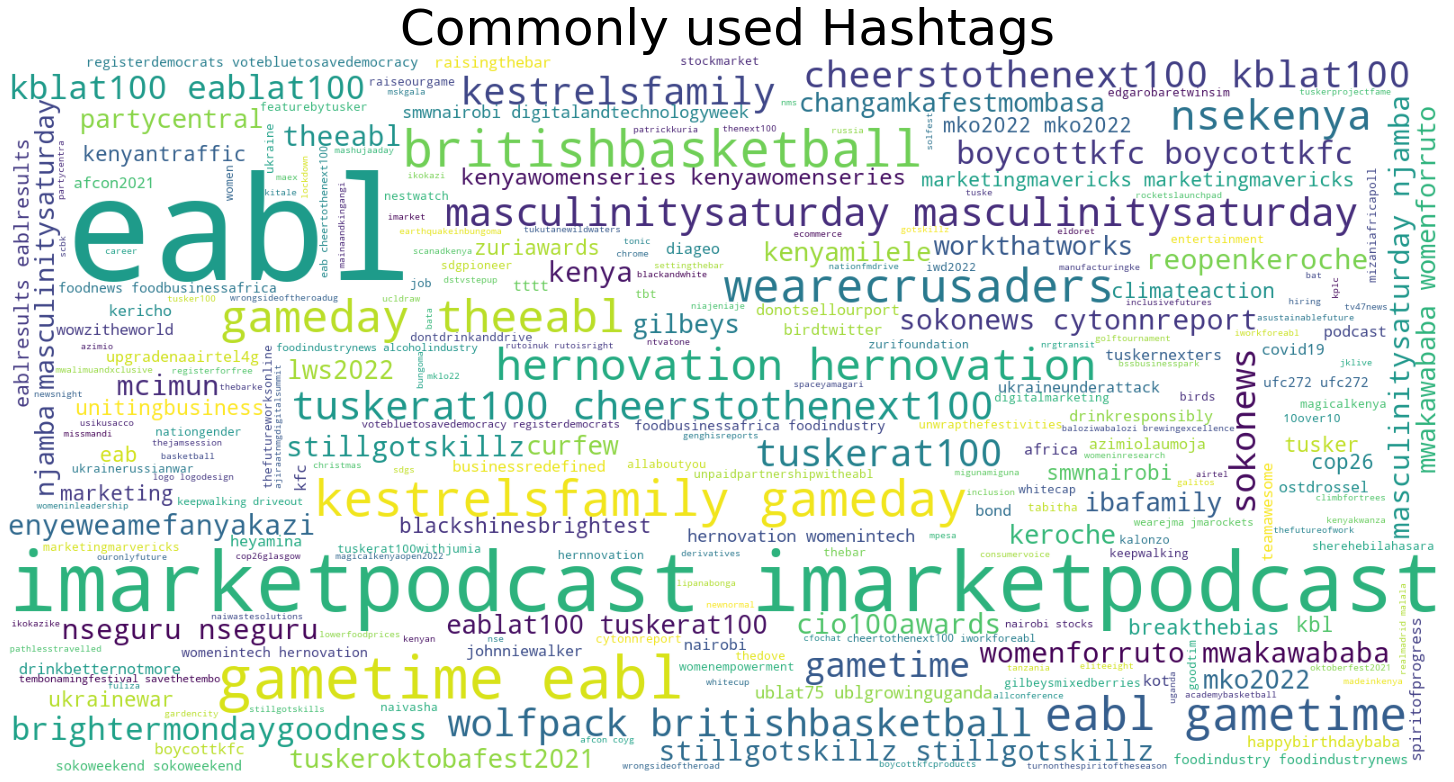

In [ ]:
# Mostly used hashtags in a word cloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="#ffffff").generate(" ".join(h_df))
plt.imshow(wc2)
plt.axis('off')
plt.title('Commonly used Hashtags', fontsize=50)
plt.tight_layout(pad=0)
plt.show()



In [ ]:
# Getting frequencies of hashtags
#
h_list = df_clean['hashtags'].to_list()
import collections
c = collections.Counter(sum(h_list, []))
hash = pd.DataFrame(c.most_common(20))
hash = bar_outlier(hash,1.5)

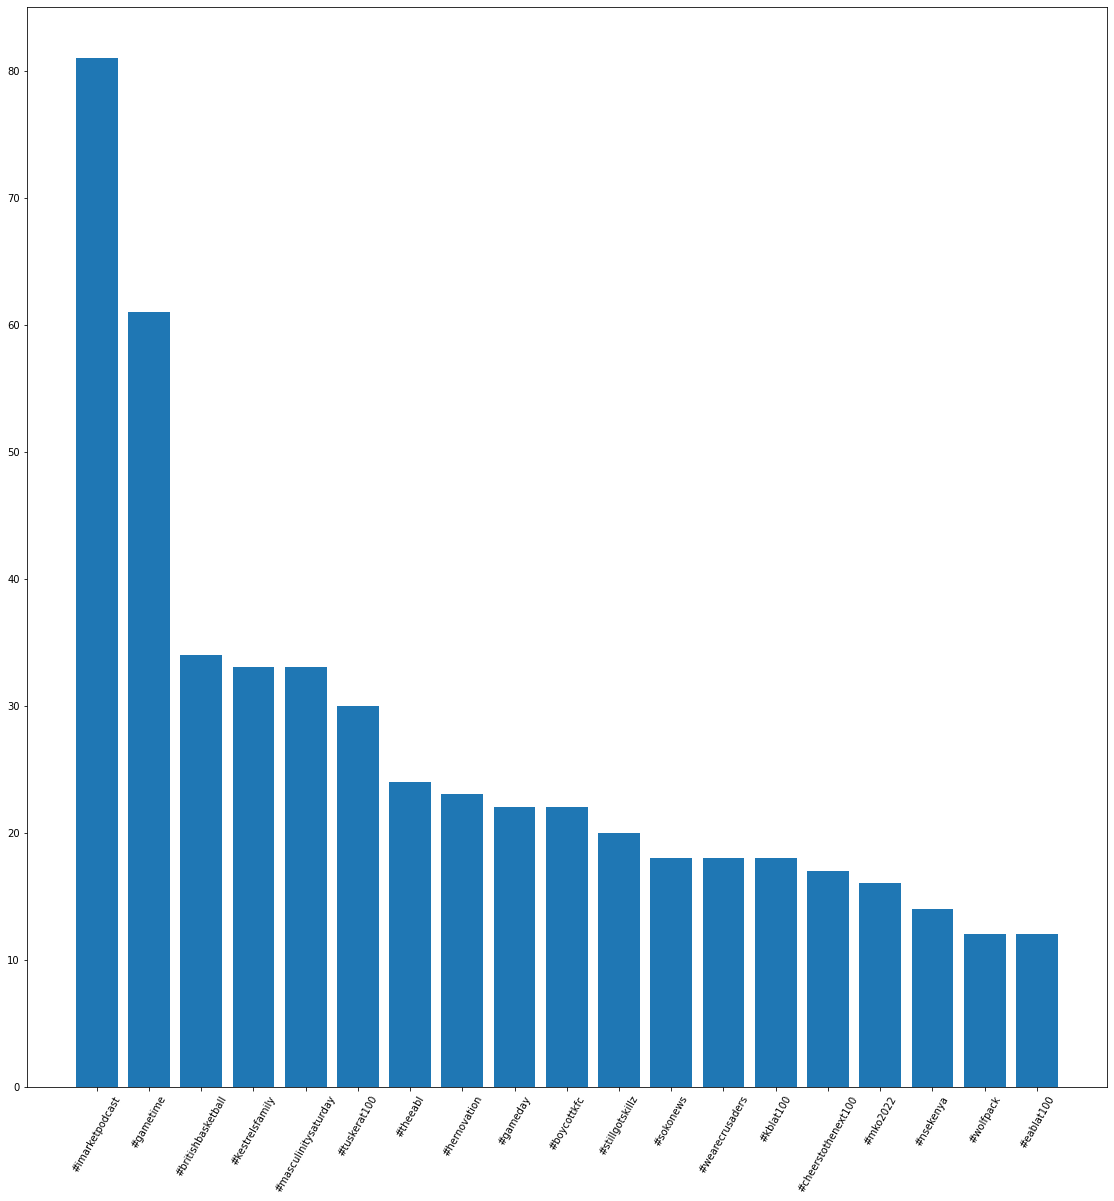

In [ ]:
# A bar plot of used hashtags
#

fig = plt.figure(figsize=(15,15))
ax = fig.add_axes([0,0,1,1])
ax.bar(hash[0],hash[1])
plt.xticks(rotation=60)
plt.show()

### Mentions

In [ ]:
# Visualizing @s on a wordcloud
#
a_df = df_clean['ats'].apply(lambda f : ' '.join(f))

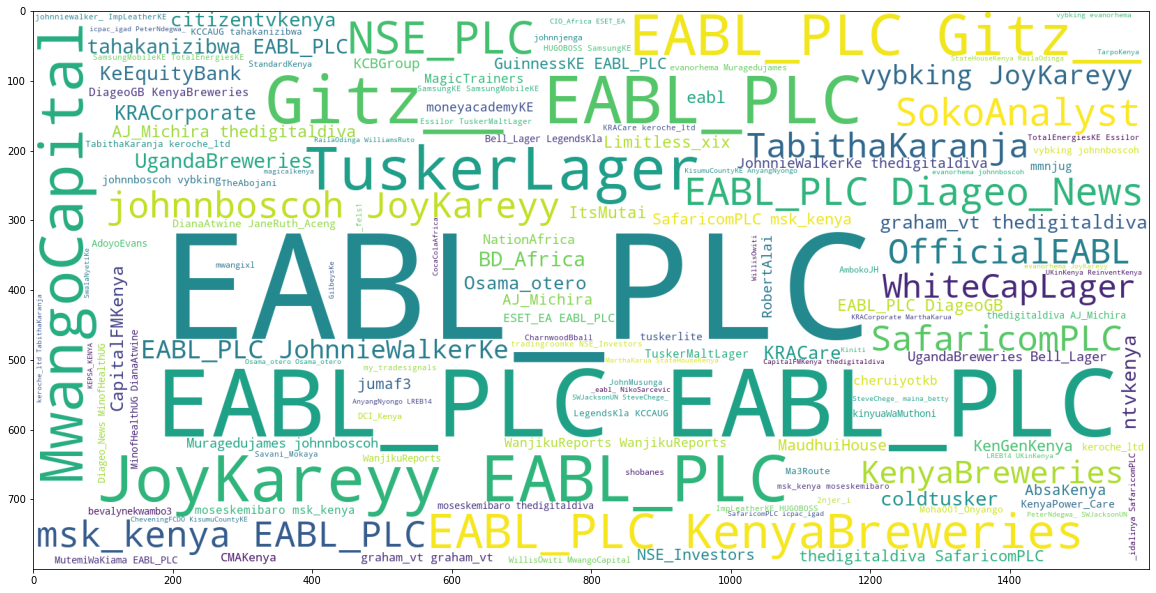

In [ ]:
# Word cloud 
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(a_df))
plt.imshow(wc2)


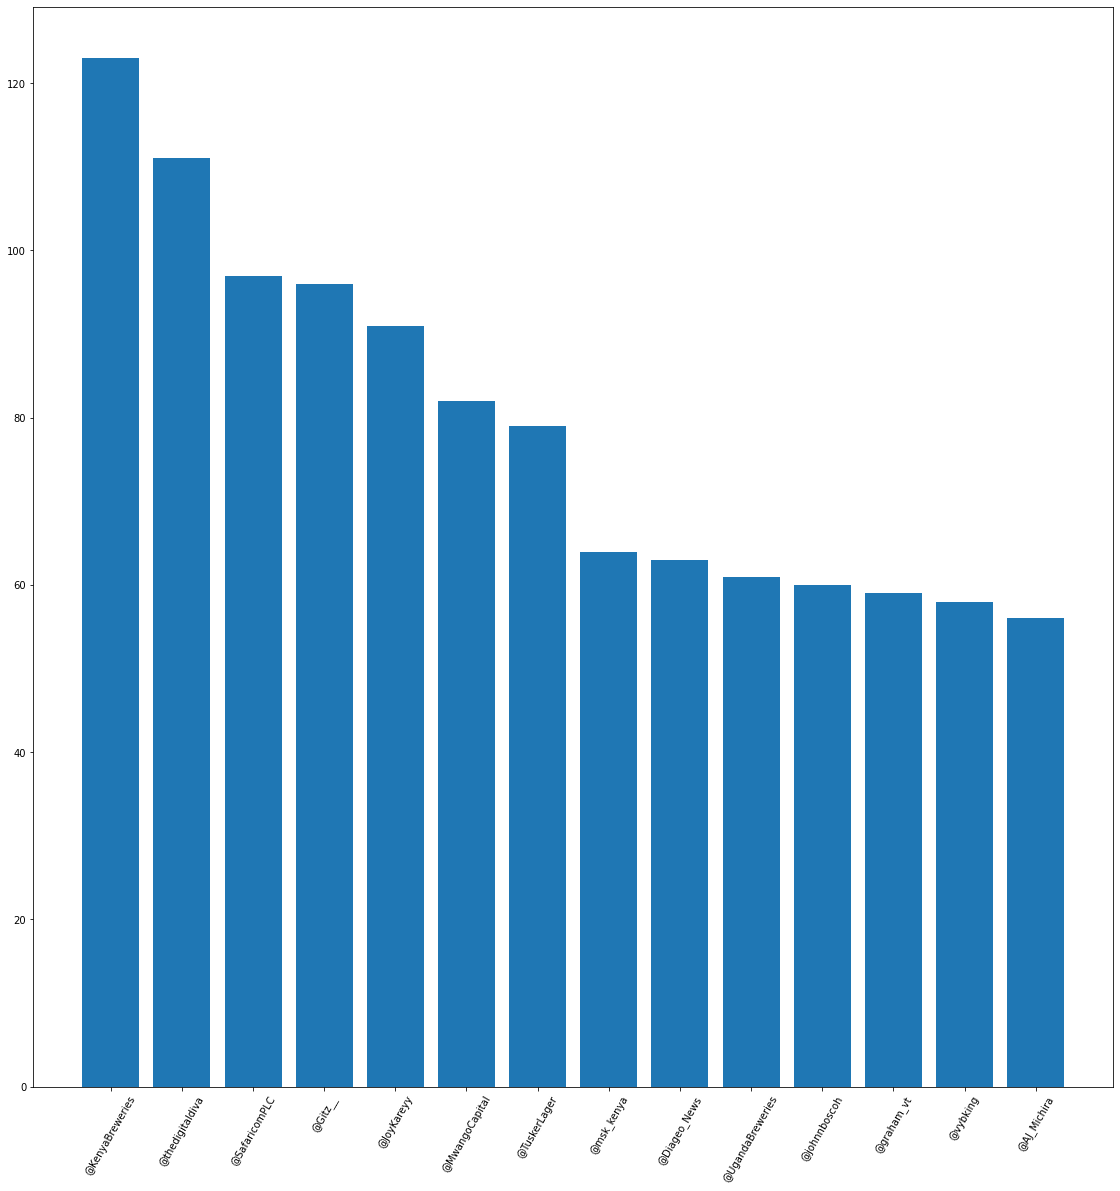

In [ ]:
# A visualization of most @s
#
make_bars(df_clean['ats'].to_list(), 15, (15,15), 1.5)

### Most Common words in tweet

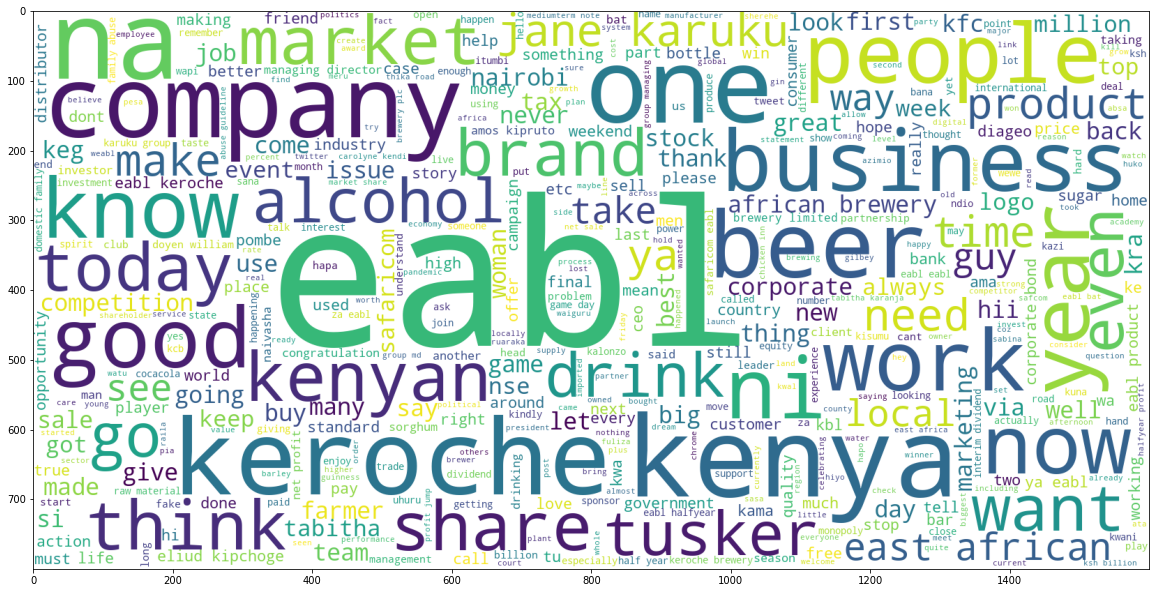

In [ ]:
w_df = df_clean['m_tweet']

# Plotting most common words in a WordCloud
#
plt.figure(figsize=(20,20))
wc2 = WordCloud(max_words=2000, min_font_size=10, height=800, width=1600, 
        background_color="white").generate(" ".join(w_df))
plt.imshow(wc2)

In [ ]:
# splitting the m_tweet to individual words

w_df = df_clean['m_tweet'].apply(lambda a : a.split()).to_list()


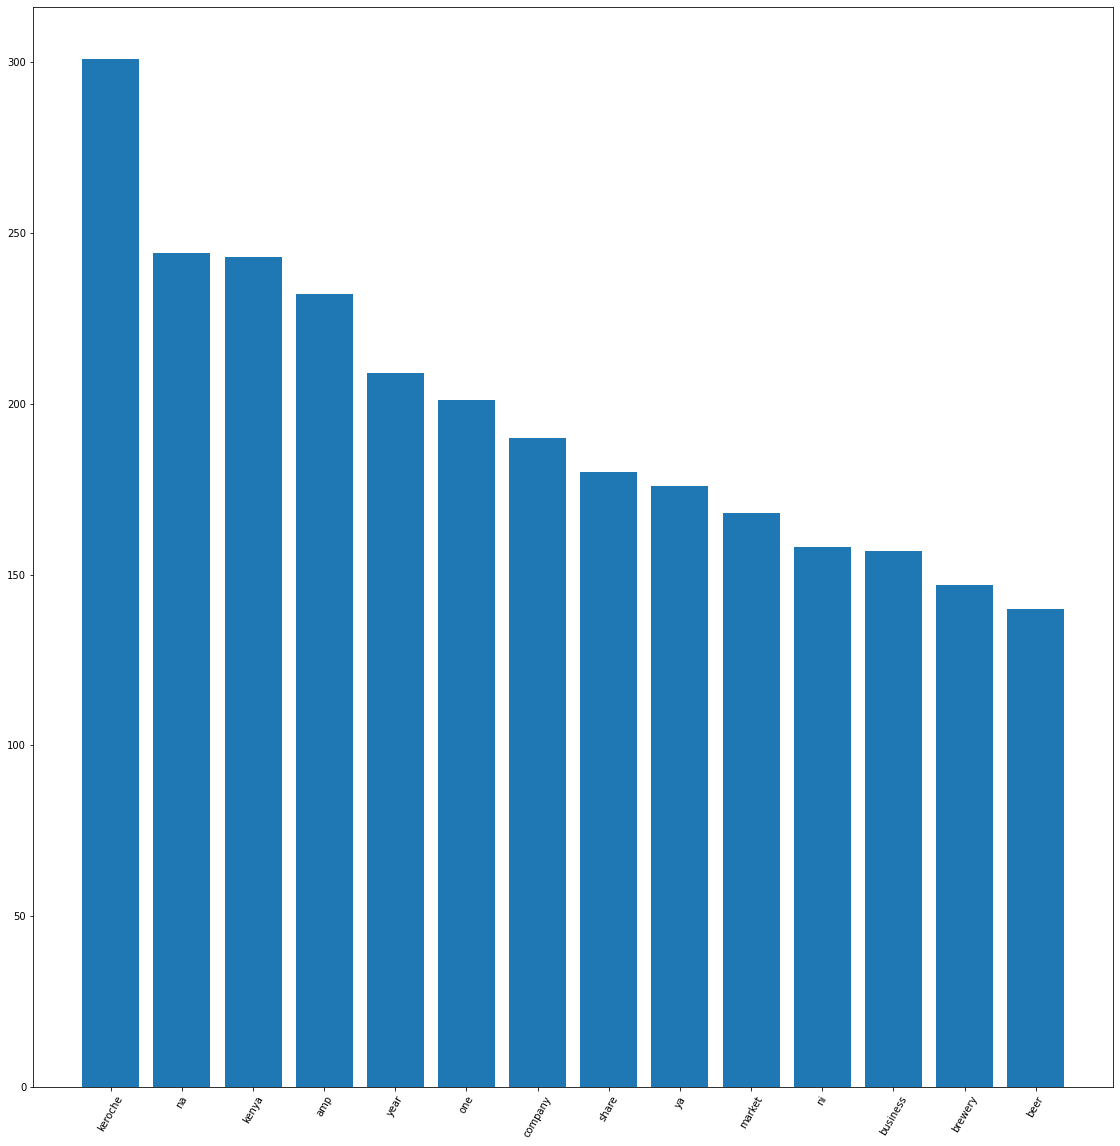

In [ ]:
# Visualizing most common words in a bar plot
#
make_bars(w_df , 15, (15,15), 1.5)

### Pie Chart of Hashtags & Mentions

In [ ]:
df_clean['pie'] = df_clean.apply(lambda r : for_pie(r['hashtags'], r['ats']) , axis = 1)

# Checking to see the key and value of each assigned number ie 0, 1, 2, 3

pie = collections.Counter(df_clean['pie'].to_list())
pie

Counter({0: 947, 1: 2633, 2: 463, 3: 594})

In [ ]:
# Getting the values 
pie.values()

dict_values([2633, 947, 594, 463])

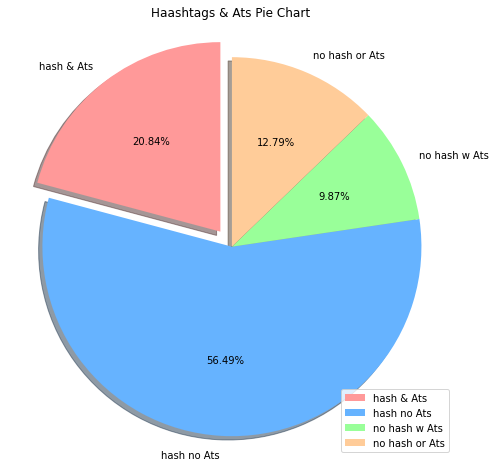

In [ ]:
# Visualizing hastags and ats in a pie chart
#
labels= ['hash & Ats', 'hash no Ats', 'no hash w Ats', 'no hash or Ats']

colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']

sizes= [984, 2667, 466, 604]

plt.figure(figsize =(8, 8))
plt.pie(sizes,labels=labels, colors=colors, startangle=90, shadow=True,explode=(0.1, 0.0, 0.0, 0.0), autopct='%1.2f%%')

plt.title('Haashtags & Ats Pie Chart')

plt.axis('equal')
plt.legend(loc="lower right")
plt.show()

### Word Count

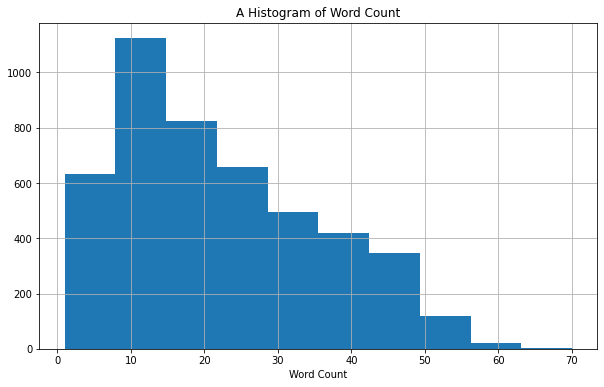

In [ ]:
# A histigrom of no of words 
#
plt.figure(figsize =(10, 6))
df_clean['no_of_words'].hist()
plt.title("A Histogram of Word Count")
plt.xlabel("Word Count")
plt.show();

### Length of Tweet

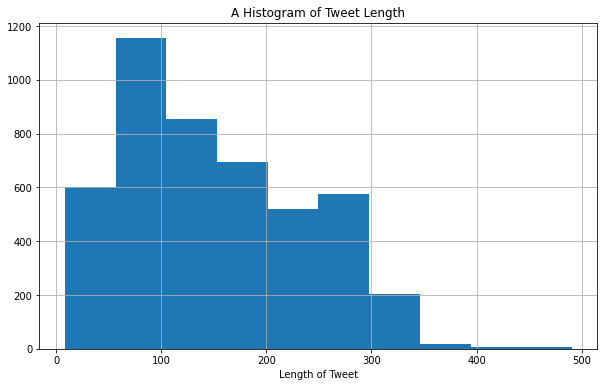

In [ ]:
# A histogram to show distribution of tweet length
#
plt.figure(figsize =(10, 6))
df_clean['length_of_tweet'].hist()
plt.title("A Histogram of Tweet Length")
plt.xlabel("Length of Tweet")
plt.show();


## Sentiment Analysis

In [ ]:
# Polarity

df_clean['polarity'] = df_clean['nr_tweet'].apply(lambda x :get_polarity(x))
df_clean[['nr_tweet', 'polarity']].sample(10)

,nr_tweet,polarity
4963,"In this country, you will wake up to find that...",0.233333
3116,@SokoAnalyst But EABL is a major offtaker of o...,-0.015625
2777,@RobertAlai Wapi competition ya @KPLC? Nowhere...,-0.002344
3985,“I think the best thing about it was not winni...,0.250000
1906,EABL vows to promote diversity and inclusivity...,0.000000
3549,Hey hey @emirates @FlyJambojet @EABL_PLC ht...,0.000000
2505,Wale walisema wataboycott EABL wako? https://t...,0.000000
201,@NPSOfficial_KE Wacheni ujinga…. Thé act was e...,0.000000
2826,I participated in the @EABL_PLC rebrand compet...,0.375000
2218,Thank EABL for keg,0.000000


In [ ]:
# Subjectivity

df_clean['subjectivity'] = df_clean.tweet.apply(get_subjectivity)
df_clean[['tweet', 'subjectivity']].sample(10)

,tweet,subjectivity
4154,EABL investors tunaumia na serikali imenyamaza...,0.000000
4244,EABL at Ksh 160 looks very attractive.Good ent...,0.300000
927,@GunnerAfrican @MarthaKarua @keroche_ltd @KRAC...,0.100000
4461,@EABL_PLC apa ni mbwe mbwe baada ya kazi https...,0.000000
4436,@Eddiest_KE @SMWNairobi @KenicTLD @SafaricomPL...,0.000000
2890,@Greatness_tupu The followers r so fanatical.....,0.500000
1217,@ahmednasirlaw Keroche MUST pay taxes. No 2 wa...,0.385714
3994,KISERO: What we learnt from EABL bond issue\nh...,0.000000
59,@ZhengYi05970800 This is the future of content...,0.125000
2106,@bevalynekwambo3 @EABL_PLC\n@CocaColaAfrica\n@...,0.345000


In [ ]:
# Extracting sentiments score
#
df_clean['sentiment_score'] = df_clean['tweet'].apply(lambda x: TextBlob(x).sentiment[0])
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score']].sample(10)


,tweet,polarity,subjectivity,sentiment_score
4758,EABL Raises KSh37.9 Bn From Domestic Market f...,0.000000,0.100000,0.000000
4692,"EABL's CFO, Risper Genga Ohaga, comments on 24...",0.000000,0.000000,0.000000
1844,@OtienoMwangi @SilasChogo Yes particularly wit...,0.166667,0.333333,0.166667
3621,@SirAlexas Halafu wenyewe pamoja na EABL wakue...,0.000000,0.000000,0.000000
4724,"@clemomsanii Hiyo excise ndo wazimu,your produ...",0.022321,0.261607,0.022321
1222,👟Canvas Rubber Shoes.\n🤑Ksh 2000.\n✨Sizes 39-4...,0.000000,0.000000,0.000000
3323,@vickykoech_ And it's not just farmers. Think ...,0.102778,0.647222,0.102778
4596,@thedigitaldiva @EABL_PLC @moseskemibaro @msk_...,0.000000,0.250000,0.000000
4392,@gidakabunyi @Wamuhu_ @WeruTV @CaratKe @marete...,0.000000,0.000000,0.000000
3971,@unthonina @EABL_PLC What would they do withou...,0.000000,0.000000,0.000000


In [ ]:
# Labelling sentiments to either Positive or Negative
#

df_clean['sentiment'] = df_clean.apply(lambda r : positive_negative(r['sentiment_score']) , axis = 1)
df_clean[['tweet', 'polarity', 'subjectivity', 'sentiment_score', 'sentiment']].sample(10)


,tweet,polarity,subjectivity,sentiment_score,sentiment
1324,@bett_collins254 @Kvaati Started way before th...,0.5000,0.500000,0.5000,Positive
4921,EABL shares at the current prices is a gem.\nH...,0.3000,0.566667,0.3000,Positive
1883,@dt_mwenda Ni management consultants/ advisors...,0.5000,0.500000,0.5000,Positive
747,EABL Elite 8\n\nItchen fall in the quarter fin...,0.0000,0.000000,0.0000,Positive
1754,@aturindademas @EABL_PLC Scam things as usual ...,-0.2500,0.250000,-0.2500,Negative
596,I’m a finalist in Visit Myrtle Beach’s Travel ...,0.0000,0.000000,0.0000,Positive
1134,Sunday vibes and drips🔥🔥\n40__44\nDoing it at ...,0.0000,0.000000,0.0000,Positive
4143,"One year ago, @EABL_PLC gave us this beautiful...",0.4875,0.725000,0.4875,Positive
1457,@Nucho_ Now ask who is eabl,0.0000,0.000000,0.0000,Positive
2333,@DCI_Kenya rem a story of a guy who was drinki...,0.3000,0.350000,0.3000,Positive


### Scatter plot of Polarity & Subjectivity

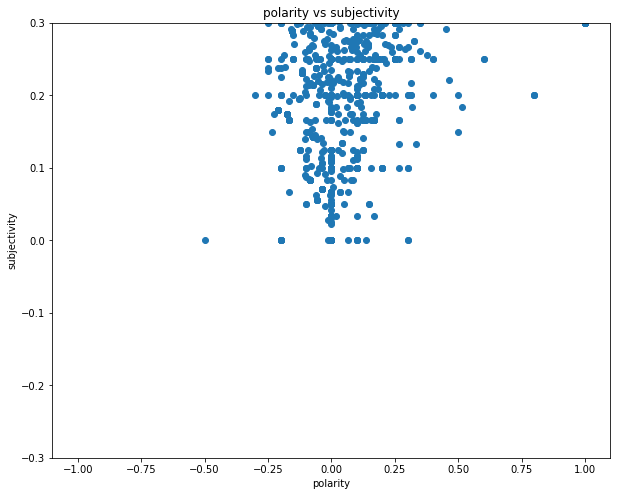

In [ ]:
# plotting the line-chart for the average polarity with the supply-chain-incidents
plt.figure(figsize =(10, 8))
plt.title("polarity vs subjectivity")
plt.xlabel("polarity")
plt.ylabel("subjectivity")
plt.ylim(-0.3, 0.3)
plt.scatter(df_clean['polarity'],	df_clean['subjectivity'])
plt.show();


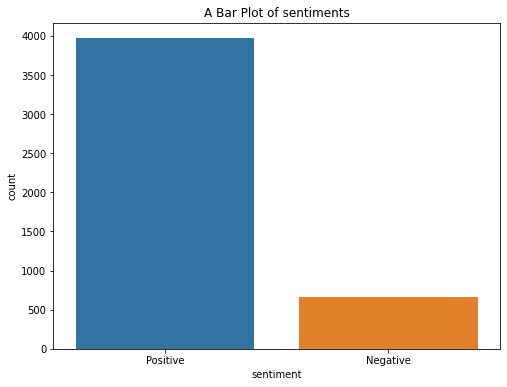

In [ ]:
# a plot of sentiments 
#
import seaborn as sns

plt.figure(figsize =(8, 6))
sns.countplot(data=df_clean, x= 'sentiment') 
plt.title("A Bar Plot of sentiments")
plt.show();


In [ ]:
# Frequency distributions of the sentiment categories
#
df_clean[['m_tweet', 'sentiment']].groupby('sentiment').describe()

m_tweet                                                            \
            count unique                                                top   
sentiment                                                                     
Negative      666    666  problem provision 1618 ableabl option after he...   
Positive     3971   3971                                     glad help this   

                
          freq  
sentiment       
Negative     1  
Positive     1

# BERT............

In [ ]:
# build our model with the Sequence Classifier and our tokenizer with BERT’s Tokenizer.
#
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
# Looking at the summary of our model
#
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Getting the dataset
#
dataset = df_clean.copy()
dataset['sentiment']

0       Positive
1       Positive
2       Negative
3       Positive
4       Positive
          ...   
4995    Positive
4997    Negative
4998    Positive
4999    Negative
5000    Positive
Name: sentiment, Length: 4637, dtype: object

In [ ]:
# Creating instance of labelencoder
#

labelencoder = LabelEncoder()

# Assigning numerical values and storing in another column
dataset['sentiment_Cat'] = labelencoder.fit_transform(dataset['sentiment'])
dataset.head()

,tweet,nr_tweet,c_tweet,hashtags,ats,m_tweet,h_tweet,a_tweet,no_of_punctuations,no_of_at,...,no_of_words_no_hash,no_of_words_no_at_hash,length_of_tweet,is_there_digit,pie,polarity,subjectivity,sentiment_score,sentiment,sentiment_Cat
0,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @EABL_PLC @OfficialEABL So gla...,@belladonnarthy @eabl_plc @officialeabl glad h...,[],"[@belladonnarthy, @EABL_PLC, @OfficialEABL]",glad help this,glad help this,@belladonnarthy @eabl_plc @officialeabl glad h...,4,3,...,8,5,75,0,1,0.500000,1.000000,0.500000,Positive,1
1,@BSCoachDev @SamNeter Plus the experience as a...,@BSCoachDev @SamNeter Plus the experience as a...,@bscoachdev @samneter plus experience whole be...,[],"[@BSCoachDev, @SamNeter]",plus experience whole better here ableabl acad...,plus experience whole better here ableabl acad...,@bscoachdev @samneter plus experience whole be...,7,2,...,24,22,176,0,1,0.220000,0.520000,0.220000,Positive,1
2,@SamNeter The problem is not provision for 16-...,@SamNeter The problem is not provision for 16-...,@samneter problem provision 1618 ableabl optio...,[],[@SamNeter],problem provision 1618 ableabl option after he...,problem provision 1618 ableabl option after he...,@samneter problem provision 1618 ableabl optio...,9,1,...,42,41,237,8,1,-0.083333,0.533333,-0.083333,Negative,0
3,What if Polycarp Igathe finds a job at eabl or...,What if Polycarp Igathe finds a job at eabl or...,polycarp igathe find job eabl kplc december ha...,[],[],polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,polycarp igathe find job eabl kplc december ha...,1,0,...,19,19,99,0,0,0.000000,0.000000,0.000000,Positive,1
4,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @DividendIncome_ Example:Safar...,@artofinvestmnt @dividendincome_ examplesafari...,[],"[@artofinvestmnt, @DividendIncome_]",examplesafaricom ie mpesa mtn bat ie tobacco e...,examplesafaricom ie mpesa mtn bat ie tobacco e...,@artofinvestmnt @dividendincome_ examplesafari...,7,2,...,11,9,102,0,1,0.000000,0.000000,0.000000,Positive,1


# Modelling

## Class Imbalance

In [ ]:
# Performing oversampling to deal with our class imbalance 
# This is because undersampling requires a large number of records which we don't have in our case

# Let's start by seeing the shape of our classes
positive = dataset[dataset['sentiment_Cat']==1]
negative = dataset[dataset['sentiment_Cat']==0]

print(positive.shape,negative.shape)

(3971, 23) (666, 23)


In [ ]:
# Splitting our dataset into dependent and independent variables

X = dataset['m_tweet'].values.reshape(-1, 1)
y = dataset['sentiment_Cat'].values.reshape(-1, 1)

print(X.shape, y.shape)

(4637, 1) (4637, 1)


In [ ]:
# Performing oversampling
from imblearn.over_sampling import RandomOverSampler
os = RandomOverSampler(sampling_strategy=0.5)
X_res, y_res = os.fit_resample(X,y)

In [ ]:
# The new shape of our X and y variables
print(X_res.shape,y_res.shape)

(5956, 1) (5956,)


In [ ]:
# Checking for the imbalance of the sentiment columns

dataset['sentiment_Cat'].value_counts()

1    3971
0     666
Name: sentiment_Cat, dtype: int64

In [ ]:
# Checking to see that we corrected the imbalance

np.unique(y_res, return_counts=True)

(array([0, 1]), array([1985, 3971]))

In [ ]:
# Splitting
#
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [ ]:
# Having a preview of four random tweets
X_train

array([['httpstcoxucmbhco6v'],
       ['qp hightops ksh 1500 sizes 4045 0729317944 4 orders bihi tower 5th flr rm 3 we deliver countrywide keroche kcse eabl kipkoech tabitha makueni hussein httpstcon6jsatyi4s'],
       ['hi idea partner install point sale system wine spirit afford selling products shooting shot dhenks'],
       ...,
       ['eabl scared stiff kericho'],
       ['eabl little meow meow'],
       ['competition eabl owns 99 market share meanwhile jifunze kuweka comma typing almost ran breath']],
      dtype=object)

In [ ]:
# Importing the BERT model and get embeding vectors for few sample statements
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

INFO:absl:Using /tmp/tfhub_modules to cache modules.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3, Total size: 1.96MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'.
INFO:absl:Downloading TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.
INFO:absl:Downloaded https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4, Total size: 429.66MB
INFO:absl:Downloaded TF-Hub Module 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'.


In [ ]:
# Get embeding vectors for few sample words. Compare them using cosine similarity
e = get_sentence_embeding([
    "bread", 
    "grapes",
    "mango",
    "Jasmine Wakini",
    "Ruth Nguli",
    "Billiah Kerubo"
]
)

In [ ]:
cosine_similarity([e[0]],[e[1]])

array([[0.9748135]], dtype=float32)

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.85866576]], dtype=float32)

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
# The summary of our BERT model:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_type_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128)}                                                      

In [ ]:
# Length of X_train and X_test
print(len(X_train))
print(len(X_test))

4764
1192


In [ ]:
# Obtaining the metrics needed for our assessment
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=METRICS)

In [ ]:
# Training the model
model.fit(X_train, y_train, epochs=10)

Epoch 1/10
149/149 [==============================] - 117s 706ms/step - loss: 0.6315 - accuracy: 0.6625 - precision: 0.6726 - recall: 0.9635
Epoch 2/10
149/149 [==============================] - 104s 700ms/step - loss: 0.6129 - accuracy: 0.6742 - precision: 0.6872 - recall: 0.9400
Epoch 3/10
149/149 [==============================] - 104s 700ms/step - loss: 0.6059 - accuracy: 0.6730 - precision: 0.6894 - recall: 0.9286
Epoch 4/10
149/149 [==============================] - 104s 701ms/step - loss: 0.5984 - accuracy: 0.6728 - precision: 0.6950 - recall: 0.9085
Epoch 5/10
149/149 [==============================] - 104s 701ms/step - loss: 0.5914 - accuracy: 0.6824 - precision: 0.6998 - recall: 0.9183
Epoch 6/10
149/149 [==============================] - 104s 700ms/step - loss: 0.5873 - accuracy: 0.6879 - precision: 0.7056 - recall: 0.9139
Epoch 7/10
149/149 [==============================] - 104s 699ms/step - loss: 0.5841 - accuracy: 0.6841 - precision: 0.7046 - recall: 0.9073
Epoch 8/10
14

In [ ]:
# Model evaluation
model.evaluate(X_test, y_test)

38/38 [==============================] - 27s 684ms/step - loss: 0.5743 - accuracy: 0.6888 - precision: 0.6910 - recall: 0.9595


[0.5743479132652283, 0.688758373260498, 0.6909753680229187, 0.9594936966896057]

In [ ]:
# Prediction
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 1, 0, ..., 0, 1, 1])

In [ ]:
# Confusion matrx
cm = confusion_matrix(y_test, y_predicted)
cm

array([[ 63, 339],
       [ 32, 758]])

Text(69.58333333333334, 0.5, 'Truth')

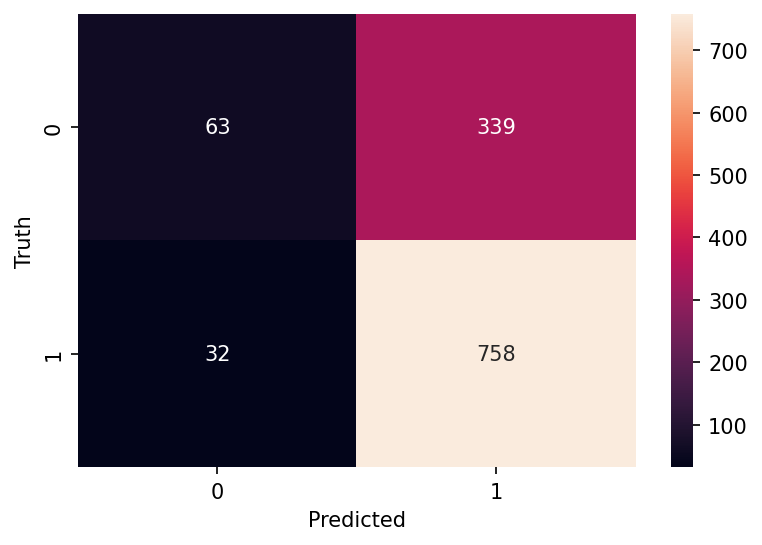

In [ ]:
# Visualizing the confusion matrix

plt.figure(dpi=150)
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [ ]:
# Classification report
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.66      0.16      0.25       402
           1       0.69      0.96      0.80       790

    accuracy                           0.69      1192
   macro avg       0.68      0.56      0.53      1192
weighted avg       0.68      0.69      0.62      1192



In [ ]:
# Inference
sentiments = [
    "april kengen dividend may equity dividend june dtb dividend december eabl dividend etc etc 30 company giving dividend 12 months roughly 2 company give dividend per month", 
    "congratulations randolph worthy battle well fought"]
model.predict(sentiments)

array([[0.55846614],
       [0.81033665]], dtype=float32)

## Challenging the Solution

### Naive Bayes

In [ ]:
# Finally, we will transform the data into occurrences, 
# which will be the features that we will feed into our model
# 

from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(ngram_range=(1,2))    # Unigram and Bigram
counts = count_vectorizer.fit_transform(dataset['m_tweet'])  
counts

<4637x56029 sparse matrix of type '<class 'numpy.int64'>'
	with 107189 stored elements in Compressed Sparse Row format>

In [ ]:
# We could leave it as the simple word-count per message, but it is better to use Term Frequency Inverse Document Frequency, more known as tf-idf
# 
from sklearn.feature_extraction.text import TfidfTransformer

transformer = TfidfTransformer().fit(counts)

counts_tfid = transformer.transform(counts)

In [ ]:
from sklearn.feature_extraction.text import Tfid

In [ ]:
# Training the Model
# Now that we have performed feature extraction from our data, it is time to build our model. 
# We will start by splitting our data into training and test sets
# 
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(counts.toarray(), dataset['sentiment_Cat'], test_size=0.1, random_state=69)

In [ ]:
# Printing splitted dataset sizes
print("X_train_shape : ",X_train.shape)
print("X_test_shape : ",X_test.shape)
print("y_train_shape : ",y_train.shape)
print("y_test_shape : ",y_test.shape)

X_train_shape :  (4173, 56029)
X_test_shape :  (464, 56029)
y_train_shape :  (4173,)
y_test_shape :  (464,)


In [ ]:
# We will use Multinomial Naive Bayes classifier
from sklearn.naive_bayes import MultinomialNB  # Naive Bayes Classifier

model_naive = MultinomialNB().fit(X_train, y_train) 
predicted_naive = model_naive.predict(X_test)
print(np.mean(predicted_naive == y_test))

0.7543103448275862


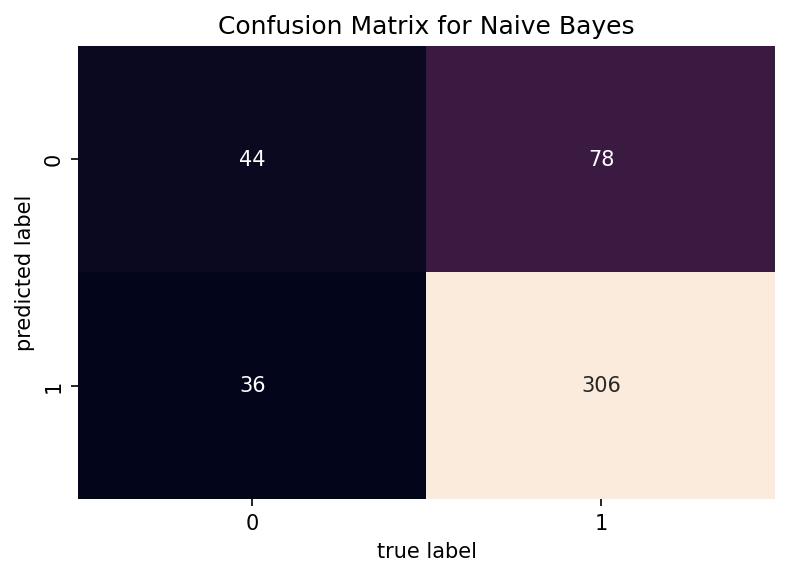

In [ ]:
# Print Confusion matrix
from sklearn.metrics import confusion_matrix

plt.figure(dpi=150)
mat = confusion_matrix(y_test, predicted_naive)
sns.heatmap(mat.T, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [ ]:
# Find out accuracy of our prediction
from sklearn.metrics import accuracy_score

score_naive = accuracy_score(predicted_naive, y_test)
print("Accuracy with Naive-bayes: ",score_naive)


Accuracy with Naive-bayes:  0.7543103448275862


In [ ]:
# Classification report
print(classification_report(y_test,predicted_naive ))

              precision    recall  f1-score   support

           0       0.36      0.55      0.44        80
           1       0.89      0.80      0.84       384

    accuracy                           0.75       464
   macro avg       0.63      0.67      0.64       464
weighted avg       0.80      0.75      0.77       464

